# Pegando VLMO(CVM art°358) do repositório da CVM

Primeiramente devemos acessar o repositório da CVM:

http://dados.cvm.gov.br/dados/

Outra maneira de ser acessar estes dados é no rad.cvm.gov.br. Este sistema é capaz de buscar as informações e apresentá-las de maneira organizada. Porém ele não é muito simples para se fazer um webscrapping. Por isso optamos por importar os dados via CSV.
https://dados.cvm.gov.br/dataset/cia_aberta-doc-vlmo/resource/2beadbf7-1772-4537-865a-b0fb5dee4487
https://www.rad.cvm.gov.br/ENET/frmConsultaExternaCVM.aspx
https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/VLMO/DADOS/vlmo_cia_aberta_2024.zip
        

## Download dos dados gerais em CSV

Download dos ZIPs que contêm as VLMOs no formato CSV.

In [3]:
import os
import requests
import zipfile

def download_and_cleanup():
    # Lista de arquivos a serem baixados
    cvmzip_list = [
        f'vlmo_cia_aberta_{y}.zip' for y in range(2018, 2025)
    ]

    # URL base
    base_url = 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/VLMO/DADOS/'

    for cvmzip in cvmzip_list:
        print(f'Arquivo: {cvmzip}')

        # Faz o download do arquivo
        response = requests.get(base_url + cvmzip, stream=True)
        with open(cvmzip, 'wb') as fp:
            print('Download...')
            fp.write(response.content)

        # Extrai o arquivo .zip
        with zipfile.ZipFile(cvmzip, 'r') as zip_ref:
            print('Unzip...')
            zip_ref.extractall()

        # Remove o arquivo .zip
        if os.path.exists(cvmzip):
            print(f'Removendo arquivo .zip: {cvmzip}')
            os.remove(cvmzip)

        # Remove os arquivos extraídos que começam com "vlmo_cia_aberta_yyyy"
        extracted_files = [
            f for f in os.listdir('.') if f.startswith(cvmzip.replace('.zip', ''))
        ]
        for file in extracted_files:
            print(f'Removendo arquivo extraído: {file}')
            os.remove(file)

# Executa a função
download_and_cleanup()


Arquivo: vlmo_cia_aberta_2018.zip
Download...
Unzip...
Removendo arquivo .zip: vlmo_cia_aberta_2018.zip
Removendo arquivo extraído: vlmo_cia_aberta_2018.csv
Arquivo: vlmo_cia_aberta_2019.zip
Download...
Unzip...
Removendo arquivo .zip: vlmo_cia_aberta_2019.zip
Removendo arquivo extraído: vlmo_cia_aberta_2019.csv
Arquivo: vlmo_cia_aberta_2020.zip
Download...
Unzip...
Removendo arquivo .zip: vlmo_cia_aberta_2020.zip
Removendo arquivo extraído: vlmo_cia_aberta_2020.csv
Arquivo: vlmo_cia_aberta_2021.zip
Download...
Unzip...
Removendo arquivo .zip: vlmo_cia_aberta_2021.zip
Removendo arquivo extraído: vlmo_cia_aberta_2021.csv
Arquivo: vlmo_cia_aberta_2022.zip
Download...
Unzip...
Removendo arquivo .zip: vlmo_cia_aberta_2022.zip
Removendo arquivo extraído: vlmo_cia_aberta_2022.csv
Arquivo: vlmo_cia_aberta_2023.zip
Download...
Unzip...
Removendo arquivo .zip: vlmo_cia_aberta_2023.zip
Removendo arquivo extraído: vlmo_cia_aberta_2023.csv
Arquivo: vlmo_cia_aberta_2024.zip
Download...
Unzip...
Rem

## Carregar os dados

Agora carregar os dados com o Pandas

In [ ]:
#teste2

import pandas as pd
import matplotlib.pyplot as plt

def calcular_balanco_e_plotar(csv_file, nome_companhia, empresa, tipo_cargo):
    # Carregar o arquivo CSV
    try:
        df = pd.read_csv(csv_file, delimiter=';', encoding='latin1')  # Ajuste o delimitador se necessário
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return
    
    # Filtrar os dados com base nos critérios fornecidos
    filtro = (
        (df['Nome_Companhia'] == nome_companhia) &
        (df['Empresa'] == empresa) &
        (df['Tipo_Cargo'] == tipo_cargo)
    )
    df_filtrado = df[filtro]
    
    # Garantir que 'Data_Referencia' esteja em formato de data
    df_filtrado['Data_Referencia'] = pd.to_datetime(df_filtrado['Data_Referencia'], errors='coerce')
    
    # Verificar se há dados filtrados
    if df_filtrado.empty:
        print("Nenhum dado encontrado com os critérios fornecidos.")
        return
    
    # Adicionar coluna para o mês e ano de referência
    df_filtrado['Mes_Ano'] = df_filtrado['Data_Referencia'].dt.to_period('M')
    
    # Calcular saldo (PN, Saldo Inicial, Crédito)
    saldo = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] == 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Crédito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()
    
    # Calcular vendas (PN, Não Saldo Inicial, Débito)
    vendas = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] != 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Débito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()
    
    # Calcular balanço mensal
    balanco = saldo.subtract(vendas, fill_value=0)
    
    # Converter o índice para datetime (para plotagem)
    balanco.index = balanco.index.to_timestamp()
    
    # Plotar o gráfico de balanço
    plt.figure(figsize=(10, 6))
    plt.plot(balanco.index, balanco.values, marker='o', linestyle='-', label='Balanço Mensal')
    plt.title(f'Balanço Mensal da Série Histórica {tipo_cargo} da {nome_companhia}')
    plt.xlabel('Mês de Referência')
    plt.ylabel('Balanço (Quantidade)')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Parâmetros de exemplo
csv_file = 'vlmo_cia_aberta_con_2024.csv'  # Substitua pelo nome do arquivo CSV
nome_companhia = 'RAÍZEN S.A.'
empresa = 'RAÍZEN S.A.'
tipo_cargo = 'Diretor ou Vinculado'

# Chamada da função
calcular_balanco_e_plotar(csv_file, nome_companhia, empresa, tipo_cargo)


In [ ]:
#teste 3
import pandas as pd
import plotly.express as px

def calcular_balanco_e_plotar(csv_file, nome_companhia, empresa, tipo_cargo):
    # Carregar o arquivo CSV
    try:
        df = pd.read_csv(csv_file, delimiter=';', encoding='latin1')  # Ajuste o delimitador se necessário
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return
    
    # Filtrar os dados com base nos critérios fornecidos
    filtro = (
        (df['Nome_Companhia'] == nome_companhia) &
        (df['Empresa'] == empresa) &
        (df['Tipo_Cargo'] == tipo_cargo)
    )
    df_filtrado = df[filtro]
    
    # Garantir que 'Data_Referencia' esteja em formato de data
    df_filtrado['Data_Referencia'] = pd.to_datetime(df_filtrado['Data_Referencia'], errors='coerce')
    
    # Verificar se há dados filtrados
    if df_filtrado.empty:
        print("Nenhum dado encontrado com os critérios fornecidos.")
        return
    
    # Adicionar coluna para o mês e ano de referência
    df_filtrado['Mes_Ano'] = df_filtrado['Data_Referencia'].dt.to_period('M')
    
    # Calcular saldo (PN, Saldo Inicial, Crédito)
    saldo = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] == 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Crédito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()
    
    # Calcular vendas (PN, Não Saldo Inicial, Débito)
    vendas = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] != 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Débito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()
    
    # Calcular balanço mensal
    balanco = saldo.subtract(vendas, fill_value=0)
    
    # Converter o índice para datetime (para plotagem)
    balanco.index = balanco.index.to_timestamp()
    
    # Criar um DataFrame para plotagem
    df_balanco = pd.DataFrame({'Data': balanco.index, 'Balanço': balanco.values})
    
    # Plotar o gráfico interativo com Plotly
    fig = px.line(
        df_balanco,
        x='Data',
        y='Balanço',
        title=f'Balanço Mensal da Série Histórica ({tipo_cargo}) da {nome_companhia}',
        labels={'Data': 'Mês de Referência', 'Balanço': 'Balanço (Quantidade)'},
        markers=True
    )
    
    fig.update_layout(
        xaxis=dict(title='Mês de Referência', tickangle=45),
        yaxis=dict(title='Balanço (Quantidade)'),
        template='plotly_white'
    )
    
    fig.show()

# Parâmetros de exemplo
csv_file = 'vlmo_cia_aberta_con_2024.csv'  # Substitua pelo nome do arquivo CSV
nome_companhia = 'RAÍZEN S.A.'
empresa = 'RAÍZEN S.A.'
tipo_cargo = 'Diretor ou Vinculado'

# Chamada da função
calcular_balanco_e_plotar(csv_file, nome_companhia, empresa, tipo_cargo)


In [ ]:
#teste 4
import pandas as pd
import plotly.express as px
import glob
import os

def calcular_balanco_e_plotar_diretorio(diretorio, nome_companhia, empresa, tipo_cargo):
    # Obter todos os arquivos CSV correspondentes no diretório
    arquivos_csv = glob.glob(os.path.join(diretorio, 'vlmo_cia_aberta_con_*.csv'))
    
    if not arquivos_csv:
        print("Nenhum arquivo correspondente encontrado no diretório.")
        return
    
    # Inicializar DataFrame para consolidar os dados
    df_consolidado = pd.DataFrame()
    
    for arquivo in arquivos_csv:
        try:
            print(f"Processando arquivo: {arquivo}")
            df = pd.read_csv(arquivo, delimiter=';', encoding='latin1')
            df_consolidado = pd.concat([df_consolidado, df], ignore_index=True)
        except Exception as e:
            print(f"Erro ao processar o arquivo {arquivo}: {e}")
    
    # Filtrar os dados com base nos critérios fornecidos
    filtro = (
        (df_consolidado['Nome_Companhia'] == nome_companhia) &
        (df_consolidado['Empresa'] == empresa) &
        (df_consolidado['Tipo_Cargo'] == tipo_cargo)
    )
    df_filtrado = df_consolidado[filtro]
    
    # Garantir que 'Data_Referencia' esteja em formato de data
    df_filtrado['Data_Referencia'] = pd.to_datetime(df_filtrado['Data_Referencia'], errors='coerce')
    
    # Verificar se há dados filtrados
    if df_filtrado.empty:
        print("Nenhum dado encontrado com os critérios fornecidos.")
        return
    
    # Adicionar coluna para o mês e ano de referência
    df_filtrado['Mes_Ano'] = df_filtrado['Data_Referencia'].dt.to_period('M')
    
    # Calcular saldo (PN, Saldo Inicial, Crédito)
    saldo = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] == 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Crédito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()
    
    # Calcular vendas (PN, Não Saldo Inicial, Débito)
    vendas = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] != 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Débito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()
    
    # Calcular balanço mensal
    balanco = saldo.subtract(vendas, fill_value=0)
    
    # Converter o índice para datetime (para plotagem)
    balanco.index = balanco.index.to_timestamp()
    
    # Criar um DataFrame para plotagem
    df_balanco = pd.DataFrame({'Data': balanco.index, 'Balanço': balanco.values})
    
    # Plotar o gráfico interativo com Plotly
    fig = px.line(
        df_balanco,
        x='Data',
        y='Balanço',
        title=f'Balanço Mensal da Série Histórica ({tipo_cargo}) da {nome_companhia}',
        labels={'Data': 'Mês de Referência', 'Balanço': 'Balanço (Quantidade)'},
        markers=True
    )
    
    fig.update_layout(
        xaxis=dict(title='Mês de Referência', tickangle=45),
        yaxis=dict(title='Balanço (Quantidade)'),
        template='plotly_white'
    )
    
    fig.show()

# Parâmetros de exemplo
diretorio = './'  # Substitua pelo diretório onde estão os arquivos
nome_companhia = 'RAÍZEN S.A.'
empresa = 'RAÍZEN S.A.'
tipo_cargo = 'Diretor ou Vinculado'

# Chamada da função
calcular_balanco_e_plotar_diretorio(diretorio, nome_companhia, empresa, tipo_cargo)


In [ ]:
#teste 5
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

def carregar_dados(diretorio):
    # Carregar os arquivos CSV do diretório
    import glob
    import os
    arquivos_csv = glob.glob(os.path.join(diretorio, 'vlmo_cia_aberta_con_*.csv'))
    if not arquivos_csv:
        return pd.DataFrame(), []

    df_consolidado = pd.DataFrame()
    for arquivo in arquivos_csv:
        try:
            df = pd.read_csv(arquivo, delimiter=';', encoding='latin1')
            df_consolidado = pd.concat([df_consolidado, df], ignore_index=True)
        except Exception as e:
            print(f"Erro ao carregar {arquivo}: {e}")

    companhias = sorted(df_consolidado['Nome_Companhia'].dropna().unique())
    empresas = sorted(df_consolidado['Empresa'].dropna().unique())
    cargos = sorted(df_consolidado['Tipo_Cargo'].dropna().unique())

    return df_consolidado, companhias, empresas, cargos

def calcular_balanco(df, nome_companhia, empresa, tipo_cargo):
    filtro = (
        (df['Nome_Companhia'] == nome_companhia) &
        (df['Empresa'] == empresa) &
        (df['Tipo_Cargo'] == tipo_cargo)
    )
    df_filtrado = df[filtro]
    if df_filtrado.empty:
        return None

    df_filtrado['Data_Referencia'] = pd.to_datetime(df_filtrado['Data_Referencia'], errors='coerce')
    df_filtrado['Mes_Ano'] = df_filtrado['Data_Referencia'].dt.to_period('M')

    saldo = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] == 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Crédito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()

    vendas = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] != 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Débito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()

    balanco = saldo.subtract(vendas, fill_value=0)
    balanco.index = balanco.index.to_timestamp()

    return balanco

# Configuração de widgets
diretorio = widgets.Text(value='./', description='Diretório:')
botao_carregar = widgets.Button(description='Carregar Dados')

out_carregar = widgets.Output()

def carregar_dados_callback(_):
    global df, companhias, empresas, cargos
    df, companhias, empresas, cargos = carregar_dados(diretorio.value)
    with out_carregar:
        out_carregar.clear_output()
        if df.empty:
            print("Nenhum arquivo correspondente encontrado no diretório.")
        else:
            print("Dados carregados com sucesso!")
            dropdown_companhia.options = companhias
            dropdown_empresa.options = empresas
            dropdown_cargo.options = cargos

botao_carregar.on_click(carregar_dados_callback)

# Widgets para seleção
dropdown_companhia = widgets.Dropdown(description='Companhia:', options=[])
dropdown_empresa = widgets.Dropdown(description='Empresa:', options=[])
dropdown_cargo = widgets.Dropdown(description='Cargo:', options=[])
botao_gerar = widgets.Button(description='Gerar Gráfico')

out_grafico = widgets.Output()

def gerar_grafico_callback(_):
    with out_grafico:
        out_grafico.clear_output()
        if not df.empty:
            balanco = calcular_balanco(df, dropdown_companhia.value, dropdown_empresa.value, dropdown_cargo.value)
            if balanco is None:
                print("Nenhum dado encontrado com os critérios fornecidos.")
            else:
                # Gráfico interativo com Plotly
                df_balanco = pd.DataFrame({'Data': balanco.index, 'Balanço': balanco.values})
                fig = px.line(
                    df_balanco,
                    x='Data',
                    y='Balanço',
                    title=f'Balanço Mensal ({dropdown_cargo.value}) - {dropdown_companhia.value}',
                    labels={'Data': 'Mês de Referência', 'Balanço': 'Balanço (Quantidade)'},
                    markers=True
                )
                fig.show()

botao_gerar.on_click(gerar_grafico_callback)

# Exibição dos widgets
display(diretorio, botao_carregar, out_carregar)
display(dropdown_companhia, dropdown_empresa, dropdown_cargo, botao_gerar, out_grafico)


In [2]:
#teste6
import os
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

def carregar_dados():
    # Diretório do notebook
    diretorio_atual = os.getcwd()
    arquivos_csv = [os.path.join(diretorio_atual, f) for f in os.listdir(diretorio_atual) if f.startswith('vlmo_cia_aberta_con_') and f.endswith('.csv')]
    
    if not arquivos_csv:
        return pd.DataFrame(), []
    
    df_consolidado = pd.DataFrame()
    for arquivo in arquivos_csv:
        try:
            df = pd.read_csv(arquivo, delimiter=';', encoding='latin1')
            df_consolidado = pd.concat([df_consolidado, df], ignore_index=True)
        except Exception as e:
            print(f"Erro ao carregar {arquivo}: {e}")
    
    companhias = sorted(df_consolidado['Nome_Companhia'].dropna().unique())
    return df_consolidado, companhias

def calcular_balanco(df, nome_companhia, empresa, tipo_cargo):
    filtro = (
        (df['Nome_Companhia'] == nome_companhia) &
        (df['Empresa'] == empresa) &
        (df['Tipo_Cargo'] == tipo_cargo)
    )
    df_filtrado = df[filtro]
    if df_filtrado.empty:
        return None

    df_filtrado['Data_Referencia'] = pd.to_datetime(df_filtrado['Data_Referencia'], errors='coerce')
    df_filtrado['Mes_Ano'] = df_filtrado['Data_Referencia'].dt.to_period('M')

    saldo = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] == 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Crédito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()

    vendas = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] != 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Débito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()

    balanco = saldo.subtract(vendas, fill_value=0)
    balanco.index = balanco.index.to_timestamp()

    return balanco

# Carregar os dados na inicialização
df, companhias = carregar_dados()

# Widgets para interação
dropdown_companhia = widgets.Dropdown(description='Companhia:', options=companhias)
dropdown_empresa = widgets.Dropdown(description='Empresa:', options=[])
dropdown_cargo = widgets.Dropdown(description='Cargo:', options=[])
botao_gerar = widgets.Button(description='Gerar Gráfico')
out_grafico = widgets.Output()

# Atualizar as empresas ao selecionar uma companhia
def atualizar_empresas(change):
    companhia_selecionada = change.new
    if companhia_selecionada:
        empresas_disponiveis = sorted(df[df['Nome_Companhia'] == companhia_selecionada]['Empresa'].dropna().unique())
        dropdown_empresa.options = empresas_disponiveis
        dropdown_cargo.options = []

dropdown_companhia.observe(atualizar_empresas, names='value')

# Atualizar os cargos ao selecionar uma empresa
def atualizar_cargos(change):
    empresa_selecionada = change.new
    if empresa_selecionada:
        cargos_disponiveis = sorted(df[df['Empresa'] == empresa_selecionada]['Tipo_Cargo'].dropna().unique())
        dropdown_cargo.options = cargos_disponiveis

dropdown_empresa.observe(atualizar_cargos, names='value')

# Gerar o gráfico
def gerar_grafico_callback(_):
    with out_grafico:
        clear_output(wait=True)
        out_grafico.clear_output()
        if dropdown_companhia.value and dropdown_empresa.value and dropdown_cargo.value:
            balanco = calcular_balanco(df, dropdown_companhia.value, dropdown_empresa.value, dropdown_cargo.value)
            if balanco is None:
                print("Nenhum dado encontrado com os critérios fornecidos.")
            else:
                # Gráfico interativo com Plotly
                df_balanco = pd.DataFrame({'Data': balanco.index, 'Balanço': balanco.values})
                fig = px.line(
                    df_balanco,
                    x='Data',
                    y='Balanço',
                    title=f'Balanço Mensal ({dropdown_cargo.value}) - {dropdown_companhia.value}',
                    labels={'Data': 'Mês de Referência', 'Balanço': 'Balanço (Quantidade)'},
                    markers=True
                )
                fig.show()

botao_gerar.on_click(gerar_grafico_callback)

# Exibição dos widgets
display(dropdown_companhia, dropdown_empresa, dropdown_cargo, botao_gerar, out_grafico)


Dropdown(description='Companhia:', options=(), value=None)

Dropdown(description='Empresa:', options=(), value=None)

Dropdown(description='Cargo:', options=(), value=None)

Button(description='Gerar Gráfico', style=ButtonStyle())

Output()

In [4]:
#teste 7
import os
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# Lista fixa de cargos possíveis
CARGOS_POSIVEIS = [
    'Diretor ou Vinculado',
    'Conselho de Administração ou Vinculado',
    'Órgão Estatutário ou Vinculado',
    'Controlador ou Vinculado',
    'Conselho Fiscal ou Vinculado'
]

def carregar_dados():
    # Diretório do notebook
    diretorio_atual = os.getcwd()
    arquivos_csv = [os.path.join(diretorio_atual, f) for f in os.listdir(diretorio_atual) if f.startswith('vlmo_cia_aberta_con_') and f.endswith('.csv')]
    
    if not arquivos_csv:
        return pd.DataFrame(), []
    
    df_consolidado = pd.DataFrame()
    for arquivo in arquivos_csv:
        try:
            df = pd.read_csv(arquivo, delimiter=';', encoding='latin1')
            df_consolidado = pd.concat([df_consolidado, df], ignore_index=True)
        except Exception as e:
            print(f"Erro ao carregar {arquivo}: {e}")
    
    companhias = sorted(df_consolidado['Nome_Companhia'].dropna().unique())
    return df_consolidado, companhias

def calcular_balanco(df, nome_companhia, empresa, tipo_cargo):
    filtro = (
        (df['Nome_Companhia'] == nome_companhia) &
        (df['Empresa'] == empresa) &
        (df['Tipo_Cargo'] == tipo_cargo)
    )
    df_filtrado = df[filtro]
    if df_filtrado.empty:
        return None

    df_filtrado['Data_Referencia'] = pd.to_datetime(df_filtrado['Data_Referencia'], errors='coerce')
    df_filtrado['Mes_Ano'] = df_filtrado['Data_Referencia'].dt.to_period('M')

    saldo = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] == 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Crédito') &
        (df_filtrado['Caracteristica_Valor_Mobiliario'] == 'PN')
    ].groupby('Mes_Ano')['Quantidade'].sum()

    vendas = df_filtrado[
        (df_filtrado['Tipo_Movimentacao'] != 'Saldo Inicial') &
        (df_filtrado['Tipo_Operacao'] == 'Débito' or 'Crédito') & #mudança
        (df_filtrado['Caracteristica_Valor_Mobiliario'].isin(['PN', 'PNA', 'PNB', 'PNC']))
    ].groupby('Mes_Ano')['Quantidade'].sum()

    balanco = saldo.subtract(vendas, fill_value=0)
    balanco.index = balanco.index.to_timestamp()

    return balanco

# Carregar os dados na inicialização
df, companhias = carregar_dados()

# Widgets para interação
dropdown_companhia = widgets.Dropdown(description='Companhia:', options=companhias)
dropdown_empresa = widgets.Dropdown(description='Empresa:', options=[])
dropdown_cargo = widgets.Dropdown(description='Cargo:', options=CARGOS_POSIVEIS)
botao_gerar = widgets.Button(description='Gerar Gráfico')
out_grafico = widgets.Output()

# Atualizar as empresas ao selecionar uma companhia
def atualizar_empresas(change):
    companhia_selecionada = change.new
    if companhia_selecionada:
        empresas_disponiveis = sorted(df[df['Nome_Companhia'] == companhia_selecionada]['Empresa'].dropna().unique())
        dropdown_empresa.options = empresas_disponiveis
        # Atualizar cargos ao mudar empresa
        dropdown_cargo.options = CARGOS_POSIVEIS  # Recarregar cargos fixos

dropdown_companhia.observe(atualizar_empresas, names='value')

# Gerar o gráfico
def gerar_grafico_callback(_):
    with out_grafico:
        # Limpar a saída antes de gerar o novo gráfico
        try:    
            fig.data = []
            fig.layout = {}
            fig.close()
            px.close(fig)
        except:
            out_grafico.clear_output()
            clear_output(wait=True)
            
            if dropdown_companhia.value and dropdown_empresa.value and dropdown_cargo.value:
                balanco = calcular_balanco(df, dropdown_companhia.value, dropdown_empresa.value, dropdown_cargo.value)
                if balanco is None:
                    print("Nenhum dado encontrado com os critérios fornecidos.")
                else:
                    # Gráfico interativo com Plotly
                    df_balanco = pd.DataFrame({'Data': balanco.index, 'Balanço': balanco.values})
                    fig = px.line(
                        df_balanco,
                        x='Data',
                        y='Balanço',
                        title=f'Balanço Mensal ({dropdown_cargo.value}) - {dropdown_companhia.value}/ {dropdown_empresa}',
                        labels={'Data': 'Mês de Referência', 'Balanço': 'Balanço (Quantidade)'},
                        markers=True
                    )
                    fig.show()
botao_gerar.on_click(gerar_grafico_callback)

# Exibição dos widgets
display(dropdown_companhia, dropdown_empresa, dropdown_cargo, botao_gerar, out_grafico)


Dropdown(description='Companhia:', options=('2W ECOBANK S.A.', 'ACO VERDE DO BRASIL S.A', 'ADVANCED DIGITAL HE…

Dropdown(description='Empresa:', options=(), value=None)

Dropdown(description='Cargo:', options=('Diretor ou Vinculado', 'Conselho de Administração ou Vinculado', 'Órg…

Button(description='Gerar Gráfico', style=ButtonStyle())

Output()

Verificar a legenda e a interpretação de cada coluna com o professor
    
ON - Ação ordinária
PN - Ações preferenciais

Os dados do diretorio são atualizados semanalmente.

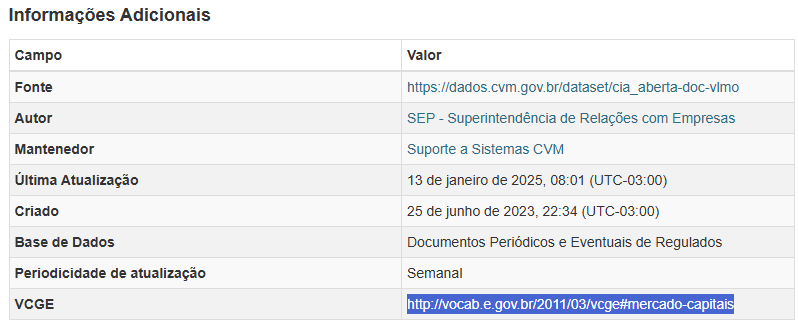

Dicionario disponivel:
-----------------------
Campo: CNPJ_Companhia
-----------------------
   Descrição : CNPJ da companhia
   Domínio   : Alfanumérico
   Tipo Dados: varchar
   Tamanho   : 20

-----------------------
Campo: Data_Referencia
-----------------------
   Descrição : Data de referência do documento
   Domínio   : AAAA-MM-DD
   Tipo Dados: date
   Tamanho   : 10

-----------------------
Campo: Nome_Companhia
-----------------------
   Descrição : Nome da Companhia
   Domínio   : Alfanumérico
   Tipo Dados: varchar
   Tamanho   : 100

-----------------------
Campo: Preco_Unitario
-----------------------
   Descrição : Preço Unitário
   Domínio   : Numérico
   Tipo Dados: decimal
   Precisão  : 38
   Scale     : 10

-----------------------
Campo: Tipo_Ativo
-----------------------
   Descrição : Tipo de Ativo (Valor Mobiliário)
   Domínio   : Alfanumérico
   Tipo Dados: varchar
   Tamanho   : 150

-----------------------
Campo: Versao
-----------------------
   Descrição : Versão do documento
   Domínio   : Numérico
   Tipo Dados: int
   Precisão  : 10
   Scale     : 0

-----------------------
Campo: Descricao_Movimentacao
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 100

-----------------------
Campo: Intermediario
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 60

-----------------------
Campo: Tipo_Cargo
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 50

-----------------------
Campo: Empresa
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 100

-----------------------
Campo: Data_Movimentacao
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: date
   Tamanho   : 10

-----------------------
Campo: Tipo_Movimentacao
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 150

-----------------------
Campo: Quantidade
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: bigint
   Precisão  : 19
   Scale     : 0

-----------------------
Campo: Caracteristica_Valor_Mobiliario
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 50

-----------------------
Campo: Volume
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: decimal
   Precisão  : 38
   Scale     : 10

-----------------------
Campo: Tipo_Empresa
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 12

-----------------------
Campo: Tipo_Operacao
-----------------------
   Descrição : 
   Domínio   : 
   Tipo Dados: varchar
   Tamanho   : 7


